setup/ import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbCallback, WandbModelCheckpoint

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
print('Tensorflow version:', tf.__version__)
print('Weights and biases version:', wandb.__version__)

Tensorflow version: 2.19.0
Weights and biases version: 0.21.1


load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/train_aug_images_160x320_no_iphone.npy')
X_val = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/val_images_160x320_no_iphone.npy')
X_test = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/test_images_160x320_no_iphone.npy')

y_train_heatmaps = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/train_aug_heatmaps_40x80_wo_iphone.npy')
y_val_heatmaps = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/val_heatmaps_40x80_wo_iphone.npy')
y_test_heatmaps = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone/test_heatmaps_40x80_wo_iphone.npy')

define hyperparameters

In [ ]:
def get_config(model_name='unet_without_iPhone_full_augmentation',
               img_size=(160, 320),
               batch_size=16,
               learning_rate_transfer=1e-3,
               learning_rate_tuning=1e-5,
               max_epochs_transfer=50,
               max_epochs_tuning=100,
               early_stop_patience=10,
               steps_per_epoch=81,
               dropout=0.5,
               seed=42):

    # cosine decay
    cosine_decay_steps = steps_per_epoch * max_epochs_tuning
    learning_schedule = {
        'initial_learning_rate': learning_rate_tuning,
        'decay_steps': cosine_decay_steps,
        'warmup_target': learning_rate_tuning,
        'warmup_steps': int(cosine_decay_steps * 0.02)
    }

    # config dictionary
    config = {
        'model_name': model_name,
        'img_size': img_size,
        'batch_size': batch_size,
        'learning_rate_transfer': learning_rate_transfer,
        'learning_rate_tuning': learning_rate_tuning,
        'max_epochs_transfer': max_epochs_transfer,
        'max_epochs_tuning': max_epochs_tuning,
        'early_stop_patience': early_stop_patience,
        'steps_per_epoch': steps_per_epoch,
        'cosine_decay_steps': cosine_decay_steps,
        'dropout': dropout,
        'learning_schedule': learning_schedule,
        'seed': seed
    }

    return config

In [ ]:
config = get_config()
SEED = config['seed']
img_size = config['img_size']
batch_size = config['batch_size']
seed = config['seed']

create tensorflow datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_heatmaps))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_heatmaps)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_heatmaps)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

define metrics // convert heatmap to coords

In [ ]:
# loss
class BCEDiceLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, smooth=1e-6, name="bce_dice_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.smooth = smooth

    def call(self, y_true, y_pred):
        # Cclamp predictions
        y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)

        # BCE
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        bce = tf.reduce_mean(bce)

        # dice
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
        pred_sum = tf.reduce_sum(y_pred, axis=[1,2])
        target_sum = tf.reduce_sum(y_true, axis=[1,2])
        dice = (2.0 * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        dice_loss = 1.0 - dice
        dice_loss = tf.reduce_mean(dice_loss)

        # combine
        loss = self.alpha * bce + (1.0 - self.alpha) * dice_loss
        return loss

# metric

# converts heatmaps in pixel coords, based on highest value (argmax)
def heatmaps_to_pixel_coords(y_heatmaps, img_size=(160,320)):
    H_img, W_img = img_size
    B,H,W,C = tf.unstack(tf.shape(y_heatmaps))

    y_flat = tf.reshape(y_heatmaps, [B, H*W, C])
    idx = tf.argmax(y_flat, axis=1, output_type=tf.int32)  # [B,C]

    x = tf.cast(idx % W, tf.float32) / tf.cast(W-1, tf.float32) * tf.cast(W_img-1, tf.float32)
    y = tf.cast(idx // W, tf.float32) / tf.cast(H-1, tf.float32) * tf.cast(H_img-1, tf.float32)

    coords = tf.stack([x,y], axis=-1)  # [B,C,2]
    return coords

# mean pixel distance (euclidean dsitance) between ground truth and predicted landamarks on img size
def mean_pixel_error(y_true, y_pred, img_size=(160,320)):
    y_true_coords = heatmaps_to_pixel_coords(y_true, img_size)
    y_pred_coords = heatmaps_to_pixel_coords(y_pred, img_size)

    dist = tf.sqrt(tf.reduce_sum(tf.square(y_true_coords - y_pred_coords), axis=-1))  # [B,C]
    return tf.reduce_mean(dist)  # scalar



define model

In [ ]:
def build_compact_unet_40x80(input_shape=(160,320,3), num_landmarks=18):
    inputs = layers.Input(shape=input_shape)

    # encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)  # 80x160

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)  # 40x80

    # bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)

    # decoder
    u1 = layers.UpSampling2D((2,2), interpolation='bilinear')(b)  # 80x160
    u1 = layers.Concatenate()([u1, c2])
    u1 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    u1 = layers.Dropout(0.1)(u1)

    u2 = layers.UpSampling2D((2,2), interpolation='bilinear')(u1)  # 160x320
    u2 = layers.Concatenate()([u2, c1])
    u2 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    u2 = layers.Dropout(0.1)(u2)

    # output 40x80
    out = layers.Conv2D(num_landmarks, 1, activation='sigmoid', padding='same')(u2)
    out = layers.AveragePooling2D(pool_size=(4,4))(out)  # 160/4=40, 320/4=80

    model = Model(inputs, out)
    return model

In [ ]:
input_shape = (160, 320, 3)
num_landmarks = 18

model = build_compact_unet_40x80(input_shape=input_shape, num_landmarks=num_landmarks)

# loss bce + loss (0.5)
loss_fn = BCEDiceLoss(alpha=0.5)

# compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate_transfer']),
              loss=loss_fn,
              metrics=[mean_pixel_error])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 320,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 320,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 160,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 160,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 160,   │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 80,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 80,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 80,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 80, 160,   │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80, 160,   │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 80, 160,   │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 80, 160,   │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 160,   │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 160, 320,  │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160, 320,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 160, 320,  │     27,680 │ concatenate_1[0]

 Total params: 472,114 (1.80 MB)

 Trainable params: 472,114 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
wandb.init(project='mosquito_landmarks',name=f"{config['model_name']}_transfer",config=config)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=config['early_stop_patience'],
    restore_best_weights=True,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode='min')

callbacks = [
    early_stopping,
    reduce_lr,
    WandbMetricsLogger(),
    WandbModelCheckpoint("wandb_model.keras")]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arlettedel (arlettedel-universit-t-hamburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=config['max_epochs_transfer'],
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 73s 276ms/step - loss: 0.6093 - mean_pixel_error: 134.9456 - val_loss: 0.5533 - val_mean_pixel_error: 202.6726 - learning_rate: 0.0010
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - loss: 0.5427 - mean_pixel_error: 126.7969 - val_loss: 0.4700 - val_mean_pixel_error: 119.9549 - learning_rate: 0.0010
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - loss: 0.4737 - mean_pixel_error: 103.1942 - val_loss: 0.4443 - val_mean_pixel_error: 78.2617 - learning_rate: 0.0010
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - loss: 0.4509 - mean_pixel_error: 93.7050 - val_loss: 0.4394 - val_mean_pixel_error: 82.5555 - learning_rate: 0.0010
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - loss: 0.4412 - mean_pixel_error: 88.9565 - val_loss: 0.4151 - val_mean_pixel_error: 67.2121 - learning_rate: 0.0010
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - loss: 0.4323 - mean_pixel_error: 87.6407 - val_loss: 0.4012 - val_mean_pi

plot loss for train and evaluation

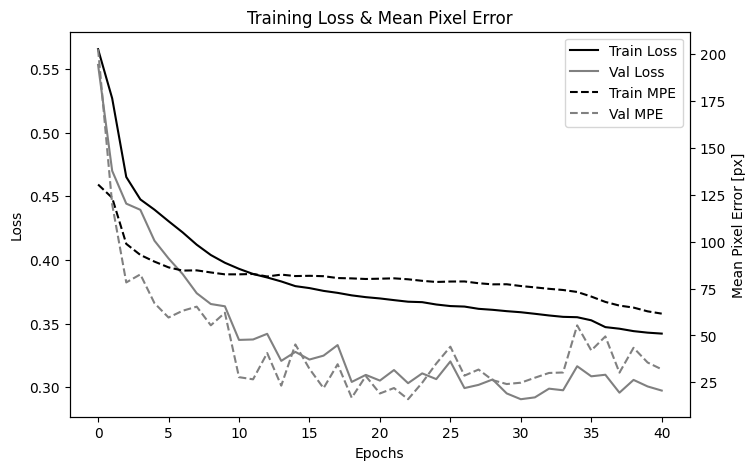

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# y1: loss
ax1.plot(history.history['loss'], label='Train Loss', linestyle='-', color='black')
ax1.plot(history.history['val_loss'], label='Val Loss', linestyle='-', color='gray')
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', labelcolor='black')

# y2: MPE
ax2 = ax1.twinx()
ax2.plot(history.history['mean_pixel_error'], label='Train MPE', linestyle='--', color='black')
ax2.plot(history.history['val_mean_pixel_error'], label='Val MPE', linestyle='--', color='gray')
ax2.set_ylabel('Mean Pixel Error [px]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Training Loss & Mean Pixel Error", color='black')
plt.show()

mini evaluation test set

In [ ]:
# converts heatmaps in normalized coordinates
def heatmaps_to_normalized_coords(y_heatmaps):
    B, H, W, C = y_heatmaps.shape
    y_flat = tf.reshape(y_heatmaps, [B, H*W, C])
    idx = tf.argmax(y_flat, axis=1, output_type=tf.int32)  # [B,C]

    # coords to pixel
    x = tf.cast(idx % W, tf.float32)
    y = tf.cast(idx // W, tf.float32)

    # normalisieren auf 0-1
    x_norm = x / (W - 1)
    y_norm = y / (H - 1)

    coords_norm = tf.stack([x_norm, y_norm], axis=-1)  # [B,C,2]
    return coords_norm.numpy()

In [ ]:
pred_heatmaps_test = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step


In [ ]:
pred_coords_norm = heatmaps_to_normalized_coords(pred_heatmaps_test)
true_coords_norm = heatmaps_to_normalized_coords(y_test_heatmaps)

In [ ]:
print(true_coords_norm.shape)
print(pred_coords_norm.shape)

(865, 18, 2)
(865, 18, 2)


In [ ]:
# image size
H, W = 160, 320

# convert to pixel size
diff_pixel = (true_coords_norm - pred_coords_norm) * np.array([H, W])
distances_pixel = np.linalg.norm(diff_pixel, axis=-1)

# prediction errors
mpe_mean = distances_pixel.mean()
mpe_std = distances_pixel.std()
mpe_median = np.median(distances_pixel)

print(f"Mean Prediction Error (MPE) in pixels: {mpe_mean:.2f} ± {mpe_std:.2f}")
print(f"Median Prediction Error in pixels: {mpe_median:.2f}")

Mean Prediction Error (MPE) in pixels: 14.86 ± 34.74
Median Prediction Error in pixels: 8.21


save predictions in normalized pixel coords for evaluation

In [ ]:
save_dir2 = '/content/drive/MyDrive/Arlette/Model_Outputs'
os.makedirs(save_dir2, exist_ok=True)
np.save(f"{save_dir2}/predictions_norm_UNET_full_augmentation_no_iPhone.npy", pred_coords_norm)

save model weights and output

In [ ]:
save_dir = '/content/drive/MyDrive/Arlette/model_weights'
os.makedirs(save_dir, exist_ok=True)

model.save(f'{save_dir}/UNET_full_augmentation_no_iPhone.keras')
model.save_weights(f'{save_dir}/UNET_full_augmentation_no_iPhone.weights.h5')